# Lab 3: Forecasting Competition - Predicting Gold Price
<img src="https://internationalbanker.com/wp-content/uploads/2021/12/Gold-Prices.png" alt="Drawing" style="width: 300px;"/>

## Instructions
<hr>

rubric={mechanics:5}

You will receive marks for correctly submitting this assignment. To submit this assignment you should:
1. Push your assignment to your GitHub repository. **Paste URL here**
2. Upload the lab `.ipynb` file to Gradescope. 
3. Double check if all the plots are rendered properly on Gradescope and the autograder returns your score.
4. If your notebook is too heavy to be rendered on Gradescope, please attach a `.pdf` as well.

## Imports
<hr>

You might need to `conda install yfinance`

In [131]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

## Forecasting Competition
<hr>

rubric={viz:10,reasoning:60,accuracy:30}

It's Week 3 - so we have a lighter lab this week. In fact, you can spend as little or as much time as you want on this lab! We will be having a little forecasting competition!

### Background and Tasks

In this week, we are going to have a live forecasting competition to predict the daily closing gold price from March 14th - March 18th. 

- You are provided with a real-time gold price dataset that refresh every day from Monday to Friday. 
- You are allowed to use as much or as little historical data as you want.
- You are allowed to use any forecasting/ML/deep learning techniques

Your tasks in this lab are simple:
1. Predict the daily closing gold price from March 14th - March 18th. Store it in a dataframe called `gold_predictions`
2. Make a plot of the training data and your predictions using any plotting library you wish. 
3. Your predictions will be evaluated 1 week after your lab's deadline.

In addition, please explain:

- Explain how far back did you use the historical data for training and why?
- Explain how you pre-process the data and how you engineer your features
- Explain which forecasting techniques did you use and why
- How you choose your parameters
- How did you deal with outliers?
- How do you evaluate your model performance & model fit?
- Reflect on the challenges that you encounter when working on this task


### Dataset

The dataset will refresh itself every weekday, so make sure to re-run the model on Saturday before submitting your results

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...
2022-03-04,1937.000000,1970.900024,1935.599976,1965.099976,1965.099976,47
2022-03-07,1989.000000,2001.099976,1963.000000,1993.900024,1993.900024,2516
2022-03-08,1999.400024,2072.000000,1998.000000,2040.099976,2040.099976,1813


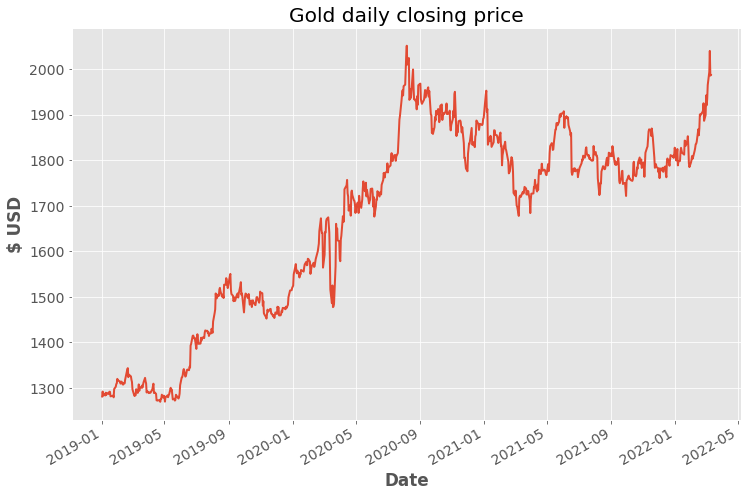

In [2]:
gold_df = yf.download('GC=F', 
                      start='2019-01-01', # YOU CAN CHANGE THIS
                      
                      end='2022-03-12', # DO NOT CHANGE THIS
                      progress=False)
gold_df['Close'].plot(title="Gold daily closing price", figsize=(12,8),ylabel='$ USD')
gold_df

In [3]:
gold_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...
2022-03-04,1937.000000,1970.900024,1935.599976,1965.099976,1965.099976,47
2022-03-07,1989.000000,2001.099976,1963.000000,1993.900024,1993.900024,2516
2022-03-08,1999.400024,2072.000000,1998.000000,2040.099976,2040.099976,1813


In [4]:
gold_df = gold_df.reset_index()

In [5]:
train = gold_df[gold_df["Date"]<"2022-03-10"]
test = gold_df[gold_df["Date"]>="2022-03-10"]

### Predictions

Store your predictions in this dataframe

In [6]:
# Test set
days = pd.date_range('2022-03-14', '2022-03-18', freq='D')
gold_predictions = pd.DataFrame({'Date': days,
                                 'Close_predict': [np.NaN]*5})
gold_predictions= gold_predictions.set_index('Date')
gold_predictions

,Close_predict
Date,
2022-03-14,NaN
2022-03-15,NaN
2022-03-16,NaN
2022-03-17,NaN
2022-03-18,NaN


In [7]:
# Validation set
days_valid = pd.date_range('2022-03-10', '2022-03-13', freq='D')
gold_predictions = pd.DataFrame({'Date': days_valid,
                                 'Close_predict': [np.NaN]*4})
gold_predictions= gold_predictions.set_index('Date')
gold_predictions

,Close_predict
Date,
2022-03-10,NaN
2022-03-11,NaN
2022-03-12,NaN
2022-03-13,NaN


### Evaluation

Following in the footsteps of the [M4 time series competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), submissions will be evaluated based on the average of two metrics:
1. Symmetric mean absolute percentage error (MAPE)

$$\text{sMAPE}=\frac{2}{h}\sum_{t=n+1}^{n+h}\frac{|y_t-\hat{y_t}|}{|y_t|+|\hat{y_t}|}*100(\%)$$

2. Mean absolute scaled error (MASE)

$$\text{MASE}=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h}|y_t-\hat{y_t}|}{\frac{1}{n-1}\sum_{t=2}^{n}|y_t-y_{t-1}|}$$

Where $y_t$ is the value of the series at time $t$, $\hat{y_t}$ is the forecast at time $t$, $h$ is the forecast horizon, $n$ is the number of training samples.

### Grading

Accuracy: 30%
Reasoning: 60%
Visualizations: 10%

In addition, I will also build my own model and submit it by Saturday. I am not gonna be able to see the test set until March 19th so I have no control over how the results will look like. If your model can beat mine, you get 5% bonus points

### Prizes

Based on accuracy

- **1st**: 100% on Lab 1, Lab 2, and Lab 3.
- **2nd**: 100% on Lab 1, Lab 2, and Lab 3.
- **3rd**: 100% on Lab 3.


## Your Code Goes Here
<hr>

In [132]:
def s_mape(y_pred, y):
    cal = abs(y - y_pred) / (abs(y) - abs(y_pred))
    return 2 * np.mean(cal) * 100


# def mase(y_pred, y, h):
#     num = np.sum(abs(y - y_pred))
#     den = np.sum(abs())
#     return (1 / h) * ( num / den)

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    return actual[:-seasonality]

def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

    

In [9]:
average = pd.DataFrame({'Date': days_valid, 
              "Close_predict": train['Close'].iloc[-5:].mean()})
                        
naive = pd.DataFrame({'Date': days_valid, 
              "Close_predict": train['Close'].iloc[-1]})
        
drift = pd.DataFrame({'Date': days_valid, 
              "Close_predict": train['Close'].iloc[-1]})
slope = (train["Close"].iloc[-1] - train["Close"].iloc[-4:]) 
drift["Close_predict"] += np.full_like(drift["Close_predict"], slope).cumsum()

In [10]:
average

,Date,Close_predict
0,2022-03-10,1983.880005
1,2022-03-11,1983.880005
2,2022-03-12,1983.880005
3,2022-03-13,1983.880005


In [11]:
naive

,Date,Close_predict
0,2022-03-10,1985.900024
1,2022-03-11,1985.900024
2,2022-03-12,1985.900024
3,2022-03-13,1985.900024


In [12]:
drift

,Date,Close_predict
0,2022-03-10,2006.700073
1,2022-03-11,1998.700073
2,2022-03-12,1944.500122
3,2022-03-13,1944.500122


## ARIMA

In [13]:
train_df = train[["Date","Close"]] 

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804 entries, 0 to 803
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    804 non-null    datetime64[ns]
 1   Close   804 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.8 KB


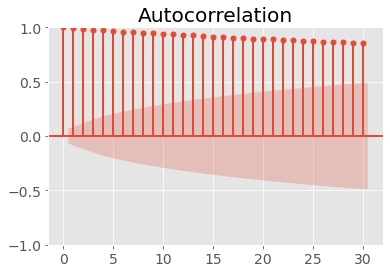

In [15]:
plot_acf(train_df["Close"]);

/Users/valliakella/opt/anaconda3/envs/mds574/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


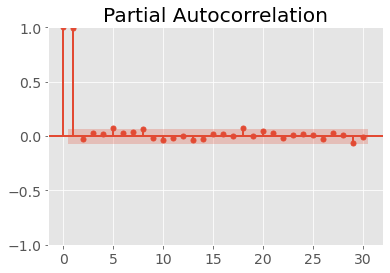

In [16]:
plot_pacf(train_df["Close"]);

In [17]:
adfuller(train_df["Close"])

(-1.22367321315892,
 0.6633301011255334,
 7,
 796,
 {'1%': -3.4385918508847646,
  '5%': -2.865177791819505,
  '10%': -2.568707096601096},
 6748.952148989889)

In [18]:
train_df = train_df.diff().dropna()

In [19]:
adfuller(train_df["Close"])

(-13.20844974428365,
 1.0590023754936545e-24,
 6,
 796,
 {'1%': -3.4385918508847646,
  '5%': -2.865177791819505,
  '10%': -2.568707096601096},
 6740.773511770437)

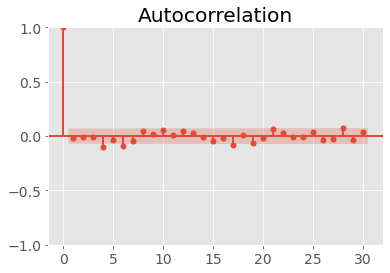

In [20]:
plot_acf(train_df["Close"]);

/Users/valliakella/opt/anaconda3/envs/mds574/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


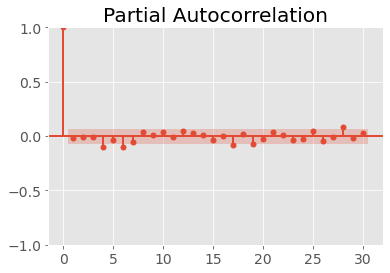

In [21]:
plot_pacf(train_df["Close"]);

## ARIMA

p = 1, d = 1, q = 0

In [22]:
model = ARIMA(train["Close"], order=(1,0,0))
results = model.fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  804
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3465.240
Date:                Thu, 10 Mar 2022   AIC                           6936.481
Time:                        00:00:58   BIC                           6950.549
Sample:                             0   HQIC                          6941.884
                                - 804                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1666.3650    167.527      9.947      0.000    1338.018    1994.712
ar.L1          0.9978      0.003    348.825      0.000       0.992       1.003
sigma2       322.2675      9.260     34.803      0.000     304.119     340.416
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               900.38
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Machine Learning 

### Feature Engineering

In [25]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
1,2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2,2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
3,2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
4,2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...,...
799,2022-03-03,1930.500000,1940.300049,1924.800049,1934.400024,1934.400024,122
800,2022-03-04,1937.000000,1970.900024,1935.599976,1965.099976,1965.099976,47
801,2022-03-07,1989.000000,2001.099976,1963.000000,1993.900024,1993.900024,2516
802,2022-03-08,1999.400024,2072.000000,1998.000000,2040.099976,2040.099976,1813


In [81]:
def feature_engineering(df):
    df["rolling_mean"] = df["Close"].rolling(window=2).mean()
    df["rolling_mean_2"] = df["Close"].rolling(window=3).mean()
    df["lag_1"] = df["Close"].shift(1)
    df["lag_2"] = df["Close"].shift(2)
    df["High-Low"] = df["High"] - df["Low"]
    df["Open-High"] = df["High"] - df["Low"]
    df["Low-Open"] = df["Open"] - df["Low"]
  
    return df

In [91]:
train = feature_engineering(train)
train = train.dropna()
X_train = train.drop(columns=['Close', 'Adj Close'])
y_train = train['Close']
#lags = 2
#last_observations = df.iloc[-1, :lag].to_numpy()
model = RandomForestRegressor()
model.fit(X_train, y_train)
                        
# #test_ump["Unemployed_pred_RF"] = recursive_forecast(last_observations, model, n=len(test_ump.index)).ravel()

RandomForestRegressor()

In [108]:
X_train.columns

Index(['Open', 'High', 'Low', 'Volume', 'rolling_mean', 'rolling_mean_2',
       'lag_1', 'lag_2', 'High-Low', 'Open-High', 'Low-Open'],
      dtype='object')

In [110]:
test = feature_engineering(test)
test["rolling_mean"].iloc[0] = train["rolling_mean"].iloc[-1]
test["rolling_mean_2"].iloc[0] = train["rolling_mean_2"].iloc[-1]
test["lag_1"].iloc[0] = train["lag_1"].iloc[-1]
test["lag_2"].iloc[0] = train["lag_2"].iloc[-1]

X_test = test.drop(columns=["Close", "Adj Close"])
y_test = test["Close"]

In [111]:
X_test.columns

Index(['Open', 'High', 'Low', 'Volume', 'rolling_mean', 'rolling_mean_2',
       'lag_1', 'lag_2', 'High-Low', 'Open-High', 'Low-Open'],
      dtype='object')

In [120]:
y_pred = model.predict(X_test)

In [121]:
y_pred

array([2001.10899902])

In [124]:
y = y_test.values

In [125]:
y

array([1987.30004883])

In [126]:
s_mape(y, y_pred)

200.0

In [133]:
mase(y, y_pred)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## LSTM